In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('../input/cyberbullying-classification/cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [3]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

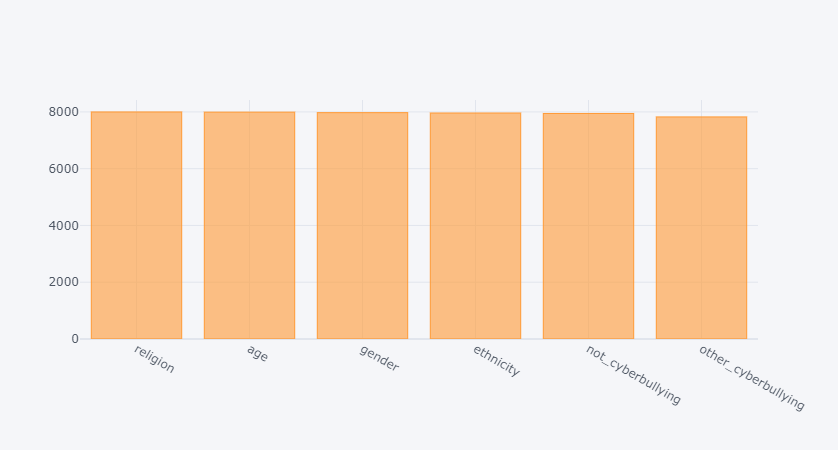

In [4]:
df['cyberbullying_type'].value_counts().iplot(kind="bar")

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
import re
clean = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
stop_words = set(stopwords.words('english'))

In [7]:
def filter_stopwords(text):
    return " ".join([word for word in word_tokenize(text) if word not in stop_words])

In [8]:
def text_preprocessing(text):
    text = re.sub(clean, ' ', text)
    text = text.lower()
    text = filter_stopwords(text)
    return text

In [9]:
def top_frequency_words(text, ng_range=(1,1), n=None):
    vector = CountVectorizer(ngram_range = ng_range, stop_words = stop_words).fit(text)
    bag_of_words = vector.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [10]:
df['tweet_text']=df['tweet_text'].apply(text_preprocessing)

In [11]:
df.head()

,tweet_text,cyberbullying_type
0,words katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying
2,classy whore red velvet cupcakes,not_cyberbullying
3,meh p thanks heads concerned another angry dud...,not_cyberbullying
4,isis account pretending kurdish account like i...,not_cyberbullying


In [12]:
from nltk.stem import WordNetLemmatizer

lematizer = WordNetLemmatizer()
def lemmatizer_words(text):
    return " ".join([lematizer.lemmatize(word, pos = 'a') for word in text.split()])
df['tweet_text'] = df['tweet_text'].apply(lambda text: lemmatizer_words(text))

In [13]:
df.head()

,tweet_text,cyberbullying_type
0,words katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying
2,classy whore red velvet cupcakes,not_cyberbullying
3,meh p thanks heads concerned another angry dud...,not_cyberbullying
4,isis account pretending kurdish account like i...,not_cyberbullying


In [14]:
def cyberbullying_type_data(cb_type, column_name='cyberbullying_type'):
    subset = df[df[column_name] == cb_type]
    text_data = subset.tweet_text.values
    return text_data

In [15]:
def most_used_words_phrases(cb_data, n=10):
    unigrams = top_frequency_words(cb_data,(1,1),n)
    unigram_data = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
    return unigram_data

In [16]:
gender_data = most_used_words_phrases(cyberbullying_type_data('gender'), 20)
religion_data = most_used_words_phrases(cyberbullying_type_data('religion'), 20)
ethnicity_data = most_used_words_phrases(cyberbullying_type_data('ethnicity'), 20)
age_data = most_used_words_phrases(cyberbullying_type_data('age'), 20)
other_cb_data = most_used_words_phrases(cyberbullying_type_data('other_cyberbullying'), 20)
not_cb_data = most_used_words_phrases(cyberbullying_type_data('not_cyberbullying'), 20)

In [17]:
def create_word_bar(data, title):
    fig = px.bar(data, x = 'Text', y = 'count', color = 'Text',
                     labels={
                         'count': "Word Frequency"
                     },
                     title=title)
    fig.show()

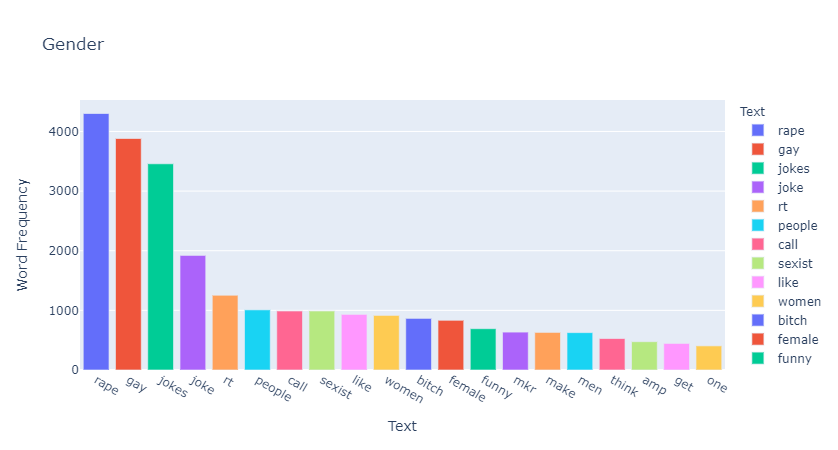

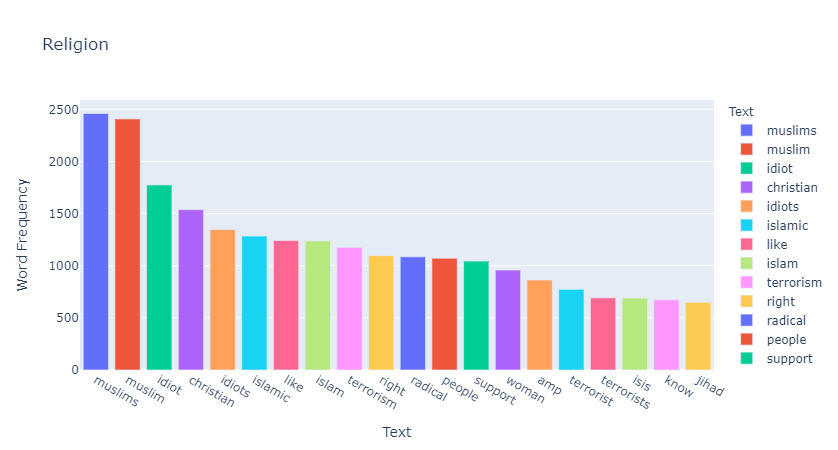

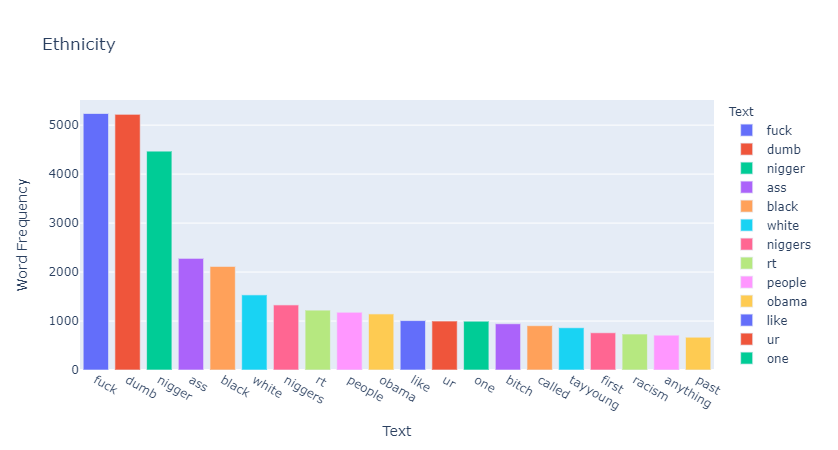

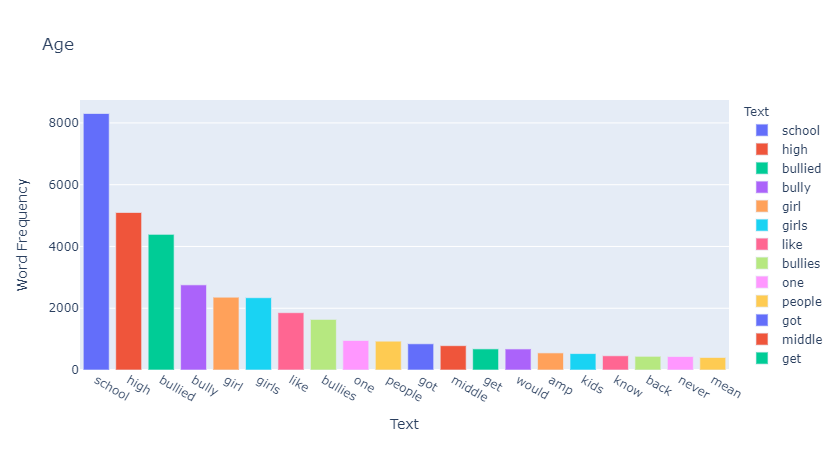

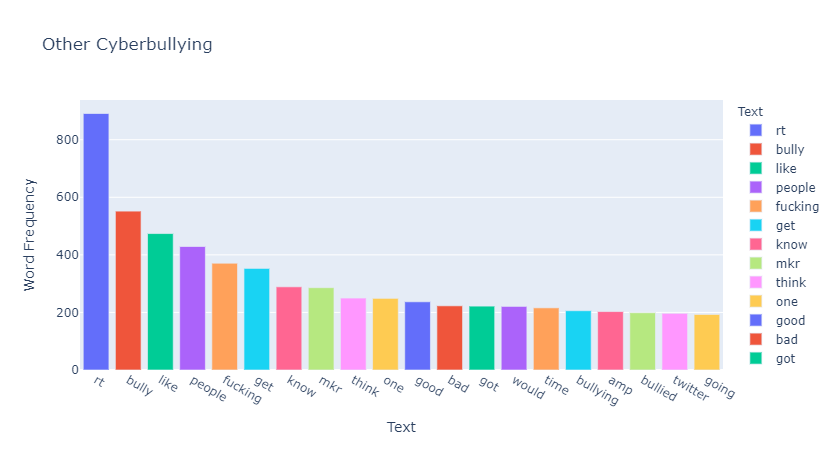

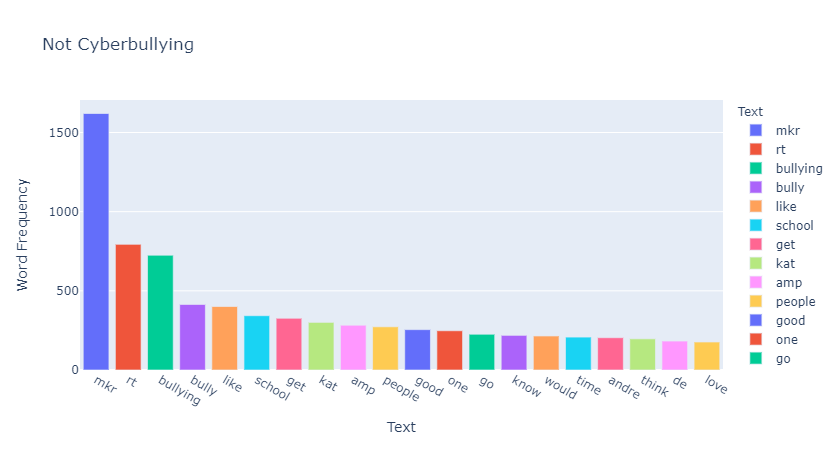

In [18]:
create_word_bar(gender_data, 'Gender')
create_word_bar(religion_data, 'Religion')
create_word_bar(ethnicity_data, 'Ethnicity')
create_word_bar(age_data, 'Age')
create_word_bar(other_cb_data, 'Other Cyberbullying')
create_word_bar(not_cb_data, 'Not Cyberbullying')

In [19]:
def create_cb_sets(cb_type):
    subset = df[df['cyberbullying_type'] == cb_type].tweet_text.values
    unigrams = top_frequency_words(subset,(1,1), 100) # Just considering the top 100 in frequencies
    unigrams_data = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
    return unigrams_data

In [20]:
gender_cb_data = create_cb_sets('gender')
age_cb_data = create_cb_sets('age')
religion_cb_data = create_cb_sets('religion')
ethnicity_cb_data = create_cb_sets('ethnicity')
other_data = create_cb_sets('other_cyberbullying')
not_data = create_cb_sets('not_cyberbullying')

In [21]:
gender_cb_data.shape

(100, 2)

In [22]:
intersecting_df = pd.merge(gender_cb_data, religion_cb_data, how='inner', on=['Text'])
modified_idf = intersecting_df.merge(age_cb_data, how='left', on=['Text']) #age

In [23]:
modified_idf.rename(columns={'count_x': 'gender', 'count_y': 'religion', 'count': 'age'}, inplace=True)

In [24]:
modified_idf = modified_idf.merge(ethnicity_cb_data, how='left', on=['Text']) #ethnicity
modified_idf.rename(columns={'count': 'ethnicity'}, inplace=True)
modified_idf = modified_idf.merge(other_data, how='left', on=['Text']) #other
modified_idf.rename(columns={'count': 'other_cb'}, inplace=True)
modified_idf = modified_idf.merge(not_data, how='left', on=['Text']) #not cb
modified_idf.rename(columns={'count': 'not cyberbullying'}, inplace=True)

In [25]:
modified_idf['age'] = modified_idf['age'].fillna(0)
modified_idf['ethnicity'] = modified_idf['ethnicity'].fillna(0)
modified_idf['other_cb'] = modified_idf['other_cb'].fillna(0)
modified_idf['not cyberbullying'] = modified_idf['not cyberbullying'].fillna(0)

In [26]:
modified_idf.isna().sum()

Text                 0
gender               0
religion             0
age                  0
ethnicity            0
other_cb             0
not cyberbullying    0
dtype: int64

In [27]:
modified_idf.head()

,Text,gender,religion,age,ethnicity,other_cb,not cyberbullying
0,rt,1254,180,0.0,1223.0,891.0,794.0
1,people,1009,1072,934.0,1180.0,429.0,273.0
2,call,990,183,0.0,275.0,88.0,0.0
3,like,933,1242,1856.0,1009.0,474.0,401.0
4,women,916,318,0.0,0.0,167.0,153.0


<a id="paralled_coordinate_graph"></a>

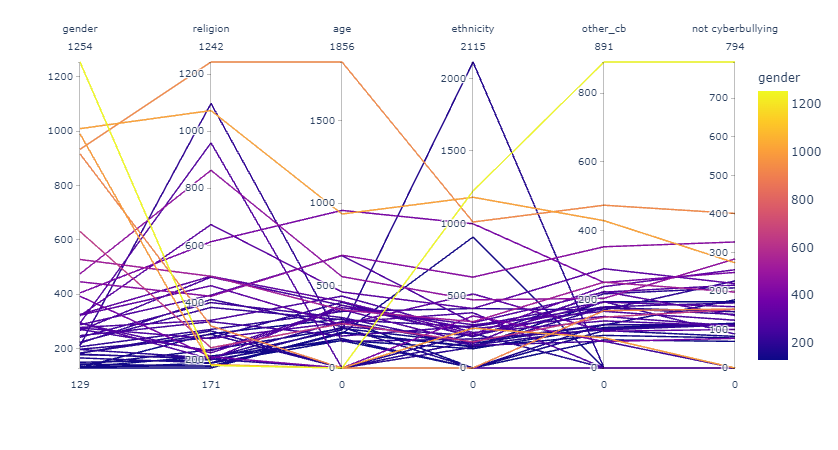

In [28]:
fig = px.parallel_coordinates(modified_idf, color='gender', labels={
                "gender": "gender",
                "religion": "religion",
                "age": "age",
                "ethnicity": "ethnicity",
                "other_cb": "other_cb",
                "not cyberbullying": "not cyberbullying"},
                )

fig.show()

In [29]:
import networkx as nx
from networkx.drawing.layout import spring_layout
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [30]:
output_notebook()

Loading BokehJS ...

In [31]:
def make_networks(cyberbullying_type):
    subset = df[df['cyberbullying_type'] == cyberbullying_type].tweet_text.values
    bigrams = top_frequency_words(subset,(2,2), 100)
    
    bigrams_list = []
    for bigram in bigrams:
        bigrams_list.append(bigram[0].split())
        
  
    graph = nx.DiGraph()

    for node in bigrams_list:
        graph.add_nodes_from([node[0]])

    for edge in bigrams_list:
        graph.add_edges_from([(edge[0], edge[1])])
    
    degrees = dict(nx.degree(graph))
    
    nx.set_node_attributes(graph, name = 'degree', values = degrees)
    number_to_adjust_by = 5
    adjusted_node_size = dict([(node, degree + number_to_adjust_by) for node, degree in nx.degree(graph)])
    nx.set_node_attributes(graph, name = 'adjusted_node_size', values = adjusted_node_size)
    
    size_by_this_attribute = 'adjusted_node_size'
    color_by_this_attribute = 'adjusted_node_size'
  
    color_palette = Blues8
    if cyberbullying_type == "ethnicity":
        color_palette = Reds8
    elif cyberbullying_type == "gender":
        color_palette = Blues8
    elif cyberbullying_type == "age":
        color_palette = Purples8
    elif cyberbullying_type == "religion":
        color_palette = Viridis8
    elif cyberbullying_type == "other_cyberbullying":
        color_palette = Oranges8
    elif cyberbullying_type == "not_cyberbullying":
        color_palette = Spectral8
        
    title = cyberbullying_type
    HOVER_TOOLTIPS = [
        ("Character", "@index"),
        ("Degree", "@degree")
    ]
    plot = figure(tooltips = HOVER_TOOLTIPS,
                  tools = "pan, wheel_zoom, save, reset", active_scroll = 'wheel_zoom',
                x_range = Range1d(-10.1, 10.1), y_range = Range1d(-10.1, 10.1), title = title)
    network_graph = from_networkx(graph, nx.spring_layout, scale=10, center = (0, 0))

    minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
    maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
    network_graph.node_renderer.glyph = Circle(size = size_by_this_attribute, 
                                               fill_color = linear_cmap(color_by_this_attribute, 
                                                                        color_palette, 
                                                                        minimum_value_color,
                                                                        maximum_value_color)
                                              )

    network_graph.edge_renderer.glyph = MultiLine(line_alpha = 0.5, line_width = 1)
    plot.renderers.append(network_graph)
    return (plot, degrees, graph)

In [32]:
gender_network_plot, gender_degree, gender_graph = make_networks('gender')
age_network_plot, age_degree, age_graph = make_networks('age')
religion_network_plot, religion_degree, religion_graph = make_networks('religion')
ethnicity_network_plot, ethnicity_degree, ethnicity_graph = make_networks('ethnicity')
other_cb_network_plot, other_cb_degree, other_cb_graph = make_networks('other_cyberbullying')
not_cb_network_plot, not_cb_degree, not_cb_graph = make_networks('not_cyberbullying')

<a id="network_plots"></a>

In [33]:
show(gender_network_plot)
show(age_network_plot)
show(religion_network_plot)
show(ethnicity_network_plot)
show(other_cb_network_plot)
show(not_cb_network_plot)

In [34]:
print('Degree of each Node in the Gender category:- ', gender_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Age category:- ', age_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Religion category:- ', religion_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Ethnicity category:- ', ethnicity_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Other Cyberbullying category:- ', other_cb_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Not Cyberbullying category:- ', not_cb_degree)
print("--------------------------------------------------------------------")

Degree of each Node in the Gender category:-  {'rape': 21, 'gay': 31, 'jokes': 18, 'joke': 7, 'prison': 2, 'miley': 2, 'date': 2, 'call': 7, 'make': 5, 'fucking': 1, 'making': 4, 'made': 3, 'cyrus': 2, 'makes': 4, 'gon': 1, 'sexist': 6, 'racist': 2, 'im': 1, 'mileycyrus': 1, 'wan': 1, 'sexual': 1, 'female': 8, 'onstage': 2, 'using': 1, 'funny': 5, 'child': 1, 'like': 2, 'females': 3, 'london': 2, 'bitch': 4, 'use': 1, '128514': 2, 'think': 3, 'never': 2, 'girlfriend': 2, 'got': 1, 'trans': 2, 'crack': 2, 'people': 3, 'years': 1, 'race': 1, 'boys': 1, 'male': 1, 'calls': 1, 'men': 1, 'insult': 1, 'na': 2, 'women': 2, 'man': 1, 'sex': 1, 'assault': 1, 'dog': 1, 'victims': 1, 'amp': 3, 'culture': 1, 'club': 1, 'slurs': 1, 'colleague': 1, 'bitches': 2, 'marriage': 1, 'etc': 1, 'ta': 1, 'fun': 1, 'ago': 1, 'nightclub': 1, 'still': 1}
--------------------------------------------------------------------
Degree of each Node in the Age category:-  {'high': 16, 'bullied': 16, 'girls': 12, 'schoo

In [35]:
# function to plot the degrees of each node
def plot_degree_of_nodes(degrees, title):
    fig = px.bar(x = list(degrees.keys()), y = list(degrees.values()), color = list(degrees.values()),
                         labels={
                             'y': "Degree",
                             'x': "Nodes"
                         },
                 title = title
                         )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

<a id="degree_bar_plots"></a>

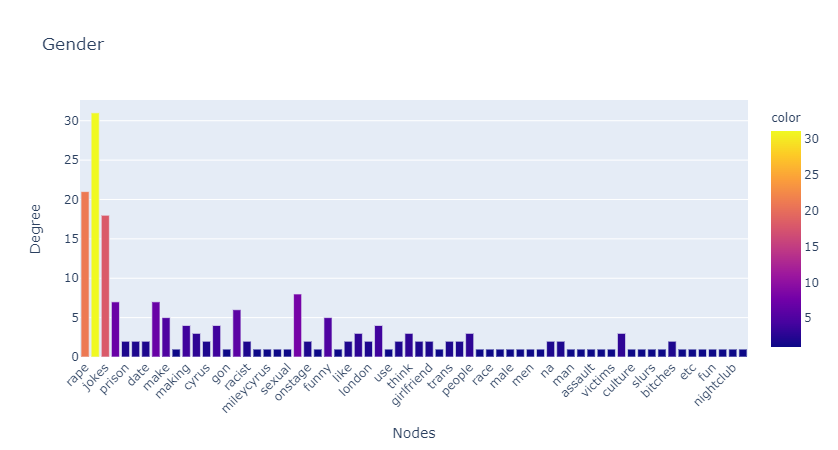

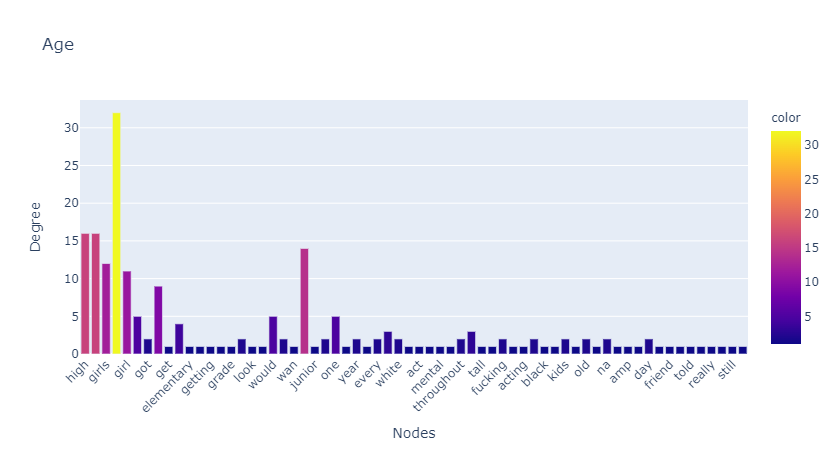

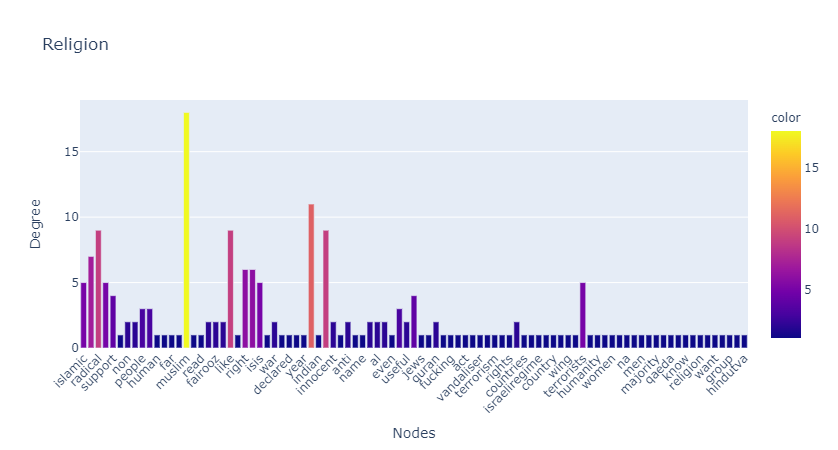

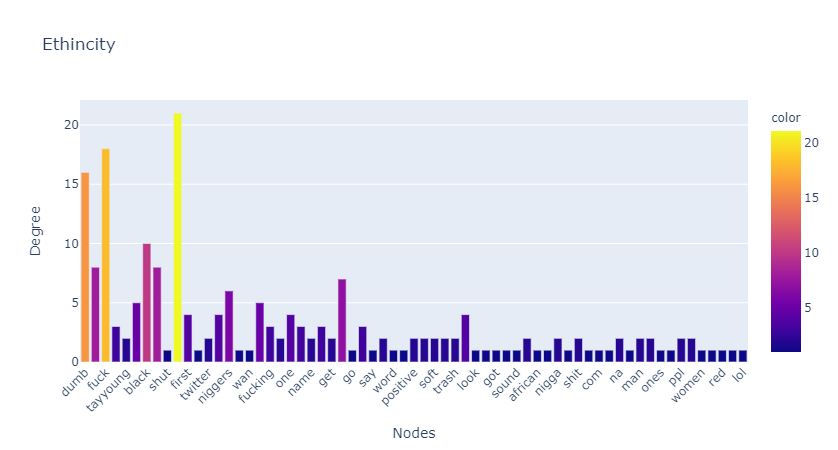

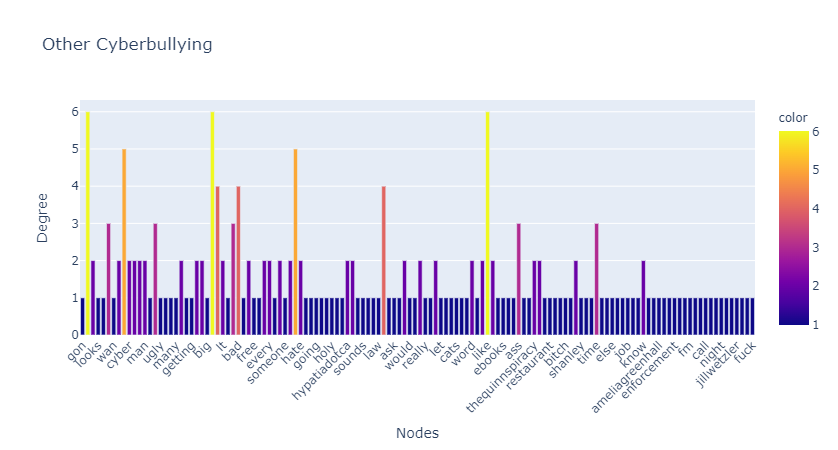

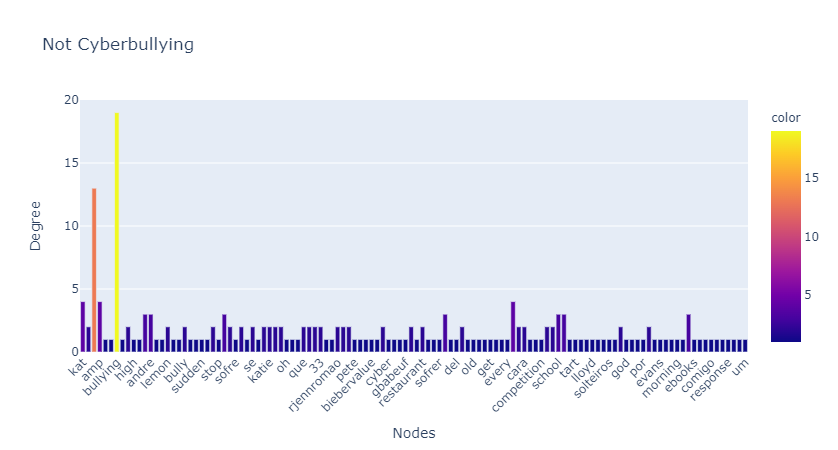

In [36]:
plot_degree_of_nodes(gender_degree, 'Gender')
plot_degree_of_nodes(age_degree, 'Age')
plot_degree_of_nodes(religion_degree, 'Religion')
plot_degree_of_nodes(ethnicity_degree, 'Ethincity')
plot_degree_of_nodes(other_cb_degree, 'Other Cyberbullying')
plot_degree_of_nodes(not_cb_degree, 'Not Cyberbullying')